In [270]:
import numpy as num
from pyrocko import gf, moment_tensor as mtm, trace
import scipy
import matplotlib.pyplot as plt
from pyrocko.gf import LocalEngine, Target, DCSource
from pyrocko.guts import Object, Float, String, Dict, Int
from pyrocko import util, pile, model, config, trace, io, pile, catalog
import time
import os
km = 1000.

We load the seismic data as a pyrocko pile and transform it to an array of seismic traces:

In [271]:
data = pile.make_pile(['aquila_realdata/'])
traces = data.all()

selecting files... done. 57 files selected.
Looking at files [------------------------------------------------------] 100% 
Scanning files [--------------------------------------------------------] 100% 


The precalculated greensfunction store with the id "global_2s_25km" needs to be downloaded in case it doesn't exist in the current directory:

In [272]:
store_id = 'global_2s_25km'
if not os.path.exists(store_id):
    ws.download_gf_store(site='kinherd', store_id=store_id)

Now we fire up the engine that is the main object to produce the synthetic traces based on the Green's Functions that are safed in the store.

In [273]:
engine = gf.LocalEngine(store_superdirs=['.']) # The Path to where the gf_store(s) are saved is given to the Engine:
store = engine.get_store(store_id)  # Load the store.

We use the snuffler catalog search for the eq. and initalize a source. This source will be used to retrieve the expected arrival times.

In [274]:
global_cmt_catalog = catalog.GlobalCMT()
tmin = util.str_to_time('2009-04-06 00:00:00')  # beginning time of query
tmax = util.str_to_time('2009-04-06 05:59:59')  # ending time of query
events = global_cmt_catalog.get_events(
        time_range=(tmin, tmax),
        magmin=6.)

event = events[0]
origin = gf.Source(
    lat=event.lat,
    lon=event.lon)
base_source = gf.MTSource.from_pyrocko_event(event)
base_source.set_origin(origin.lat, origin.lon)

Now we setup the optimization and setup a taper and filter, which will be applied to the data and synthetics.
Also we define the boundaries for the source parameters. 

In [275]:
taperer = trace.CosFader(xfade=2.0)  # Cosine taper with fade in and out of 2s.
ffreq = 0.05  # Hz, Define Filterfrequency for a lowpass filter
phase = 'P' # Phase onset to fit
tmin_fit = 15. # [s] to fit before theo. Phase onset
tmax_fit = 35. # [s] to fit after theo. Phase onset
component ='Z'
# bounds given as (min,max)
bounds = ((6.2, 6.4),  # magnitude
          (100., 140.),  # strike [deg.]
          (40., 60.),  # dip [deg.]
          (-100, -150.),  # rake [deg.]
          (3.*km, 8.*km),  # depth [km]
          (-20.*km, 20.*km),  # north shift from GCMT [km]
          (-20.*km, 20.*km),  # east shift from GCMT [km]
          (-20., 20.))  # timeshift from GCMT [s]


Next follows the loading of the stations and setup of targets.
We use the term target for a single component of a single station.

In [276]:
fn_stations = 'aquila_realdata/stations_short.txt'
stations_list = model.load_stations(fn_stations)  # load the stations file
stations = {}
for s in stations_list:
    stations[s.network, s.station, s.location] = s
    s.set_channels_by_name(*component.split())
targets = []
stations = {}

Next we define the target, if we would have several components (here only BHZ), we would also iterate over the components for each station.

In [277]:
stat_lats=[]
stat_lons=[]
for station in stations_list:  # iterate over all stations
    target = Target(
            lat=station.lat,  # station lat.
            lon=station.lon,   # station lon.
            store_id=store_id,   # The gf-store to be used for this target,
            # we can also employ different gf-stores for different targets.
            interpolation='multilinear',   # interp. method between gf cells
            quantity='displacement',   # wanted retrieved quantity
            codes=station.nsl() + ('BH'+component,))  # Station and network code
    stat_lats.append(station.lat), stat_lons.append(station.lon)
    targets.append(target)  # append all singular targets in a list

Now the objective function that will be called in the scipy.optimize function
is defined:

In [278]:
def optimization(*params):
    params = num.asarray(params)
    parameter = num.ndarray.tolist(params)
    parameter = [val for sublist in parameter for val in sublist]
    source = DCSource(
        lat=event.lat,  # Lat and lon are set to GCMT origin.
        lon=event.lon,
        north_shift=parameter[5],  # Optimize for the shift from the GCMT origin
        east_shift=parameter[6],  # in east and north direction.
        depth=parameter[4],
        strike=parameter[1],
        dip=parameter[2],
        rake=parameter[3],
        time=event.time-parameter[7],
        magnitude=parameter[0])
    engine = gf.get_engine()  # init. the engine
    # The engine is now given a source and the targets:
    response = engine.process(source, targets)
    # And then we reform the response into traces:
    synthetic_traces = response.pyrocko_traces()
    misfit_list = []  # init a list for a all the singular misfits
    norm_list = []  # init a list for a all the singular normalizations
    for to,syn,target in zip(traces, synthetic_traces,targets):
        tp = store.t(Phase, base_source, target)
        tr = to.copy()
        tr.taper(taperer), syn.taper(taperer)
        tr.lowpass(4, ffreq), syn.lowpass(4, ffreq)
        tmin = base_source.time+tp-tmin_fit  # start before theor. arrival
        tmax = base_source.time+tp+tmax_fit  # end after theor. arrival
        tr.chop(tmin=tmin, tmax=tmax), syn.chop(tmin=tmin, tmax=tmax) # cut the traces to the window that should be optimized
        misfit = num.sqrt(num.sum((tr.ydata-syn.ydata)**2))
        norm = num.sqrt(num.sum(tr.ydata**2))
        misfit_list.append(misfit), norm_list.append(norm)  # append the misfit into a list
    global_misfit_normed = num.sqrt(num.nansum((num.asarray(misfit_list))**2) / # sum all the misfits and normalize to get a single minimizable value
                                    num.nansum((num.asarray(norm_list))**2))
    print global_misfit_normed
    return global_misfit_normed

Next the the main call is defined.
Optimize.differential_evolution of scipy is used from scipy. Differential Evolution is stochastic in nature (does not use gradient methods) to find the minimium, and can search large areas of candidate space, but often requires
larger numbers of function evaluations than conventional gradient based techniques. The scipy solver can easily be exchanged for a method of your favor.

In [284]:
def solve():
    t = time.time()  # start timing
    # bounds given as (min,max)
    bounds = ((6.2, 6.4),  # magnitude
              (100., 140.),  # strike [deg.]
              (40., 60.),  # dip [deg.]
              (-100, -150.),  # rake [deg.]
              (3.*km, 8.*km),  # depth [km]
              (-20.*km, 20.*km),  # north shift from GCMT [km]
              (-20.*km, 20.*km),  # east shift from GCMT [km]
              (-20., 20.))  # timeshift from GCMT [s]
    # optimize.differential_evolution of scipy is used for the optim.
    # Differential Evolution is stochastic in nature (does not use gradient methods)
    #to find the minimium, and can search large areas of candidate space, but often requires
    #larger numbers of function evaluations than conventional gradient based techniques.
    # The scipy solver can easily be exchanged.
    result = scipy.optimize.differential_evolution(optimization, bounds=bounds, maxiter=15000,
                                                 tol=0.01)
    elapsed = time.time() - t  # get the processing time
    # Now we just print out all information that we like:
    print "Time elapsed:", elapsed
    print "Best model: "
    print "magnitude:", result.x[0], "strike:", result.x[1]
    print "dip:", result.x[2], "rake:", result.x[3], "depth:", result.x[4]
    print "north shift from GCMT in m", result.x[5], "east shift from GCMT in m:"
    print result.x[6], "time shift from GCMT in s:", result.x[7]
    return result

We want to plot the synthetics produced by the best model vs. the data. Therefore we use the result and
forward calculate synthetics. 

In [280]:
def plot_traces(result):
    source = DCSource(
     lat=event.lat,  # Lat and lon are set to GCMT origin.
     lon=event.lon,
     north_shift=result.x[5],  # Optimize for the shift from the GCMT origin
     east_shift=result.x[6],  # in east and north direction.
     depth=result.x[4],
     strike=result.x[1],
     dip=result.x[2],
     rake=result.x[3],
     time=event.time-result.x[7],
     magnitude=result.x[0])
    engine = gf.get_engine()  # init. the engine
    response = engine.process(source, targets)
    synthetic_traces = response.pyrocko_traces()
    fig, axes1 = plt.subplots(10, squeeze=True, sharex=True)
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    i=0
    k=0
    mod = (len(stat_lats) % 10)
    for to,syn,target in zip(traces, synthetic_traces,targets):
        tp = store.t(phase, base_source, target)
        tp_onset = base_source.time+tp
        tr = to.copy() 
        tr.taper(taperer), syn.taper(taperer)
        tr.lowpass(4, ffreq), syn.lowpass(4, ffreq)
        tmin = tp_onset-tmin_fit  
        tmax = tp_onset+tmax_fit  
        if k % 10 == 0 and not k ==0:
                if k==(len(stat_lats)-mod):
                        i=mod
                fig, axes1 = plt.subplots(i, squeeze=True, sharex=True)
                fig.subplots_adjust(hspace=0)
                plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
                i = 0
        tr.chop(tmin=tmin, tmax=tmax),syn.chop(tmin=tmin, tmax=tmax)
        s1=axes1[i].plot(tr.get_xdata(), tr.ydata, color='b')
        s2=axes1[i].plot(syn.get_xdata(),syn.ydata, color='r')
        s3=axes1[i].plot([tp_onset, tp_onset], [num.min(tr.ydata), num.max(tr.ydata)], 'k-', lw=2)
        axes1[i].text(-.2,0.5,str(stations_list[k].nsl()[0])+'.'+str(stations_list[k].nsl()[1]),
        transform=axes1[i].transAxes)
        axes1[i].set_yticklabels([], visible=False)
        axes1[-1].set_xlabel('Time [s]')
        plt.suptitle('Waveform fits for' +' '+ str(phase) +'-Phase and component' +' ' + str(component))
        lgd = plt.legend((s1[0], s2[0], s3[0]), ('Data','Synthetic',str(phase)+'-onset'), loc='upper center', bbox_to_anchor=(0.5, -1.6),
        fancybox=True, shadow=True, ncol=5)
        i = i+1
        k = k+1
    
    plt.show()

In [281]:
def plot_snuffler(result):
    source = DCSource(
     lat=event.lat,  # Lat and lon are set to GCMT origin.
     lon=event.lon,
     north_shift=result.x[5],  # Optimize for the shift from the GCMT origin
     east_shift=result.x[6],  # in east and north direction.
     depth=result.x[4],
     strike=result.x[1],
     dip=result.x[2],
     rake=result.x[3],
     time=event.time-result.x[7],
     magnitude=result.x[0])
    engine = gf.get_engine()  # init. the engine
    response = engine.process(source, targets)
    synthetic_traces = response.pyrocko_traces()
    syns = []
    trs = []
    
    for to,syn,target in zip(traces, synthetic_traces,targets):
        tp = store.t('P', base_source, target)
        tr = to.copy()
        tr.taper(taperer), syn.taper(taperer)
        tr.lowpass(4, ffreq), syn.lowpass(4, ffreq)
        tmin = base_source.time+tp-tmin_fit  # start 15s before theor. arrival
        tmax = base_source.time+tp+tmax_fit  # end 15s after theor. arrival
        tr.chop(tmin=tmin, tmax=tmax), syn.chop(tmin=tmin, tmax=tmax)
        trs.append(tr)
        syns.append(syn)

    trace.snuffle(trs + syns, stations=stations_list, events=events)

Next we plot the station distribution with https://matplotlib.org/basemap/

In [282]:
def plot_stations():
    from mpl_toolkits.basemap import Basemap
    width = 22000000
    m = Basemap(width=width,height=width,projection='aeqd',
                lat_0=event.lat,lon_0=event.lon)
    stat_x, stat_y = m(stat_lons,stat_lats)
    event_x, event_y = m(event.lon,event.lat)
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='lightgray',zorder=0)
    m.scatter(stat_x,stat_y,10,marker='o',color='k')
    m.scatter(event_x,event_y,30,marker='*',color='r')
    plt.title('Stations (black) for Event(red)', fontsize=12)
    plt.show()

In [283]:
result = solve() # Call of the main function to start optimizing.

1.91027214118
1.00999593342
2.06274950913
2.17004613154
2.0719496048
1.69690376731
1.50146345907
1.85113286929
1.83859313118
1.87930201421
2.29965985152
1.29076327838
1.4210761196
1.99386930416
1.50131944248
1.75506743758
1.34159152874
1.0835004672
1.96619047074
2.21770722952
2.20331687569
1.47879964495
1.72098434667
0.867718661059
2.6270228017
1.47747957043
2.06244813903
0.924885961836
1.80744202145
0.88236714406
1.54636061511
1.18234980833
1.43134447471
2.04200576547
1.51943967386
1.66882811033
1.72190421683
1.45366979264
1.50538296447
2.05252840909
1.65293160042
1.892231959
2.42472547934
1.01596468943
1.03838133431
1.96295464721
2.2534647866
0.984930031036
1.8153745678
1.45132721904
1.79238044687
1.86689859643
2.22128619874
0.972072738524
1.32810901378
1.0946605544
1.85326380498
2.04255296208
1.6872229785
2.78599153847
1.87103711425
1.13503794244
1.84379778551
1.76770795062
1.9068981084
0.729413733183
1.09815578837
2.28332814678
2.25304937881
2.28049166086
1.06849943664
1.8099733830

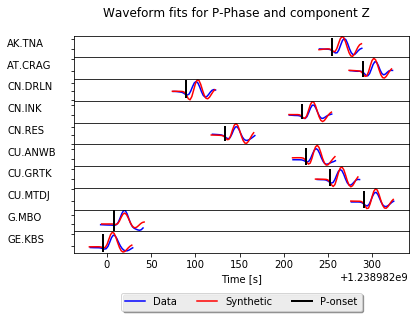

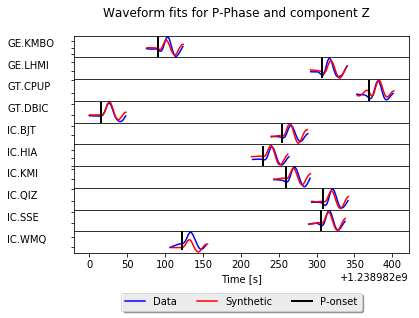

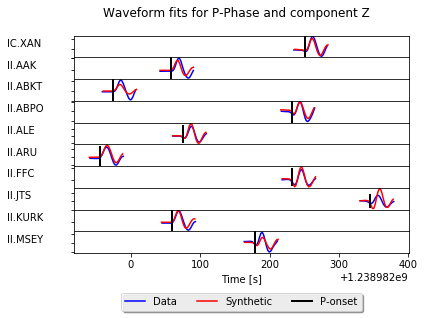

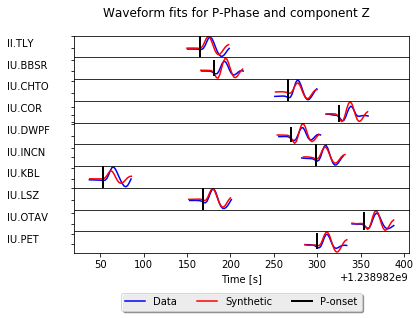

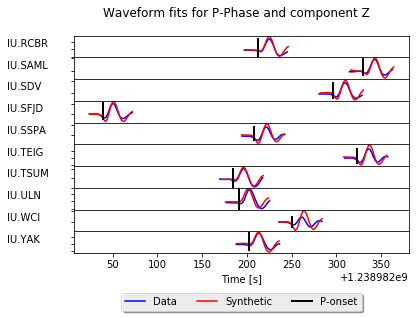

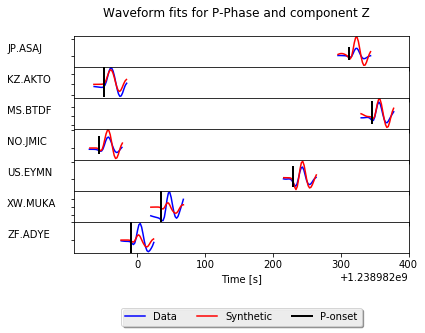

In [285]:
plot_traces(result)

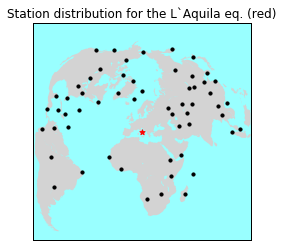

In [193]:
plot_stations()

Alternatively we can plot using snuffler, which will open in a seperate window.

In [139]:
plot_snuffler(result)

opt.py:pyrocko.snuffling    - ERROR    - Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/pyrocko/snuffling.py", line 1680, in load_if_needed
    self._module = __import__(self._name)
  File "/home/asteinbe/.snufflings/test_gradients.py", line 88, in <module>
    main()
NameError: name 'main' is not defined

opt.py:pyrocko.pile_viewer  - WARNING  - Snuffling module "/home/asteinbe/.snufflings/test_gradients.py" is broken
opt.py:pyrocko.snuffling    - ERROR    - Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/pyrocko/snuffling.py", line 1678, in load_if_needed
    raise InvalidSnufflingFilename(self._name)
InvalidSnufflingFilename: cmt

opt.py:pyrocko.pile_viewer  - WARNING  - Snuffling module "/home/asteinbe/.snufflings/cmt.py" is broken
opt.py:pyrocko.snuffling    - ERROR    - Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/pyrocko/snuffling.py", line 1680, in load_if_needed
    self._